In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
import hvplot.xarray
import cartopy.crs as crs
import torch.nn as nn
import torch
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

Matplotlib is building the font cache; this may take a moment.


In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *

In [4]:
DATADRIVE = '/datadrive_ssd/'

In [5]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2018-02'),
    val_days=5,
    split='train'
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [6]:
weights = ds_train.compute_weights()

In [7]:
sampler_train = torch.utils.data.WeightedRandomSampler(weights, len(ds_train))

In [22]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=64, sampler=sampler_train)

In [23]:
len(ds_train), len(dl_train)

(2808, 44)

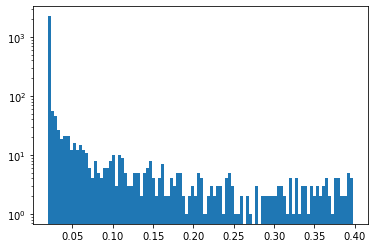

In [24]:
plt.hist(weights, bins=100)
plt.yscale('log')

In [25]:
X, y = next(iter(dl_train))

In [26]:
X.shape, y.shape

(torch.Size([64, 1, 16, 16]), torch.Size([64, 1, 128, 128]))

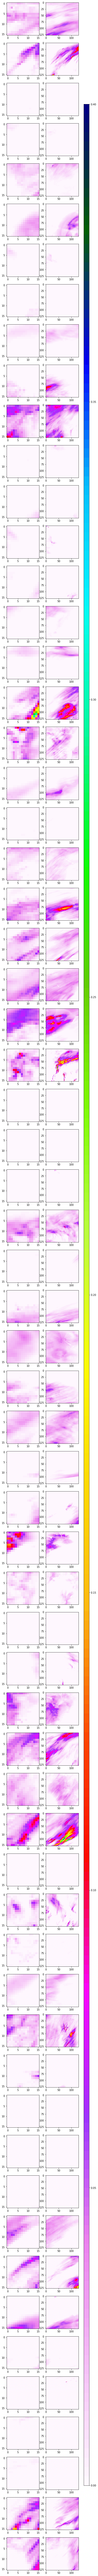

In [32]:
fig, axs = plt.subplots(64, 2, figsize=(6, 192))
for x, ax in zip([val for pair in zip(X.numpy(), y.numpy()) for val in pair], axs.flat):
    im = ax.imshow(x[0], cmap='gist_ncar_r', vmin=0, vmax=0.4)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [22]:
mean_precip = []
for idx in range(len(ds_train.idxs)):
    X, y = ds_train[idx]
    mean_precip.append(y.mean())

In [27]:
mean_precip = np.array(mean_precip)

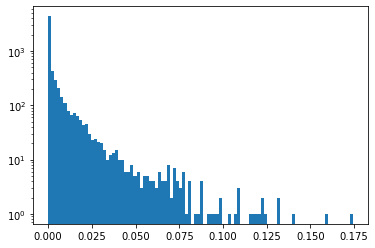

In [24]:
plt.hist(mean_precip, bins=100)
plt.yscale('log')

In [35]:
w = np.clip(mean_precip, 0.01, 0.1)

In [36]:
sampler_train = torch.utils.data.WeightedRandomSampler(w, len(ds_train))

In [37]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, sampler=sampler_train)

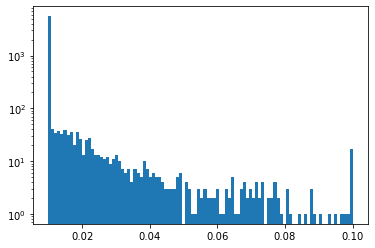

In [38]:
plt.hist(w, bins=100)
plt.yscale('log')

In [39]:
X, y = next(iter(dl_train))

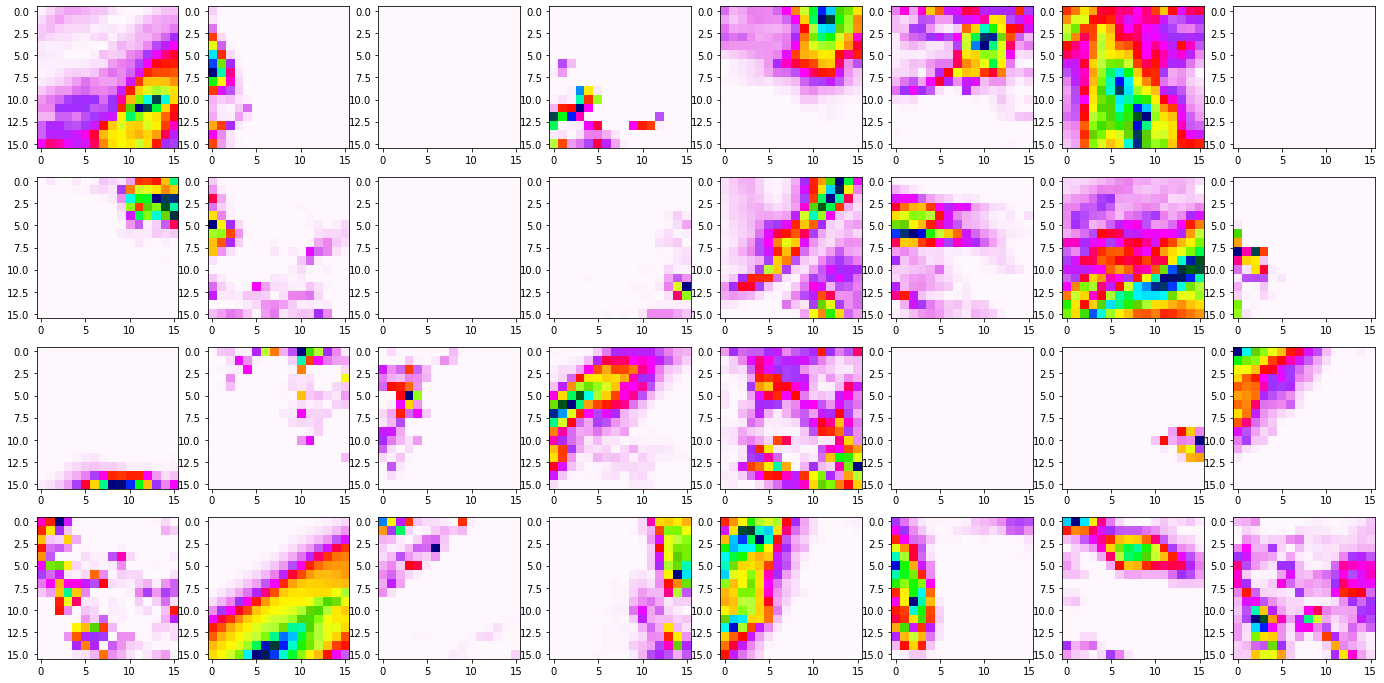

In [40]:
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for x, ax in zip(X.numpy(), axs.flat):
    ax.imshow(x[0], cmap='gist_ncar_r')